## Recurrent neural networks

The place to start seems to be [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). I'm also following the excellent Keras book p197 on RNNs.

## Setup code

In [99]:
import numpy as np
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.functional as F
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

dtype = torch.float
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [100]:
def train_test_split(X, y, test_size:float):
    n = len(X)
    shuffle_idx = np.random.permutation(range(n))
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    n_valid = int(n*test_size)
    n_train = n - n_valid
    X_train, X_valid = X[0:n_train].to(device), X[n_train:].to(device)
    y_train, y_valid = y[0:n_train].to(device), y[n_train:].to(device)
    return X_train, X_valid, y_train, y_valid

In [101]:
import matplotlib.pyplot as plt
def plot_history(history, yrange=(0.0, 5.00), figsize=(3.5,3)):
    plt.figure(figsize=figsize)
    plt.ylabel("Sentiment log loss")
    plt.xlabel("Epochs")
    loss = history[:,0]
    valid_loss = history[:,1]
    plt.plot(loss, label='train_loss')
    plt.plot(valid_loss, label='val_loss')
    # plt.xlim(0, 200)
    plt.ylim(*yrange)
    plt.legend(loc='lower right')
    plt.show()

In [102]:
def normal_transform(x, mean=0.0, std=0.01):
    "Convert x to have mean and std"
    return x*std + mean

def randn(n1, n2,
          device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
          dtype=torch.float,
          mean=0.0, std=0.01, requires_grad=False):
    x = torch.randn(n1, n2, device=device, dtype=dtype)
    x = normal_transform(x, mean=mean, std=std)
    x.requires_grad=requires_grad
    return x

In [103]:
def rtrain(model:nn.Module, train_data:TensorDataset, valid_data:TensorDataset,
           epochs=350,
           test_size=0.20,
           learning_rate = 0.002,
           batch_size=32,
           weight_decay=1.e-4,
           loss_fn=nn.MSELoss(),
           metric=nn.MSELoss(),
           print_every=30):
    "Train a regressor"
    history = []
    train_loader = DataLoader(train_data, batch_size=batch_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#     optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for ei in range(epochs): # epochs
        loss = 0
        for bi, (batch_x, batch_y) in enumerate(train_loader): # mini-batch
#             if len(batch_x)!=batch_size:
#                 print(f"\tBatch {bi:3d} len {len(batch_x)}")
            y_prob = model(batch_x)
            loss += loss_fn(y_prob, batch_y)

        optimizer.zero_grad()
        loss.backward() # autograd computes U.grad and M.grad
        optimizer.step()

        with torch.no_grad():
            loss        = loss_fn(model(train_data.tensors[0]), train_data.tensors[1])
            loss_valid  = loss_fn(model(valid_data.tensors[0]), valid_data.tensors[1])
            y_pred = model(train_data.tensors[0])
            metric_train = metric(torch.round(y_pred).cpu(), train_data.tensors[1].cpu())
            y_pred = model(valid_data.tensors[0])
            metric_valid = metric(torch.round(y_pred).cpu(), valid_data.tensors[1].cpu())

        history.append( (loss, loss_valid) )
        if ei % print_every == 0:
            print(f"Epoch {ei:3d} loss {loss:7.3f}, {loss_valid:7.3f}   {metric.__class__.__name__} {metric_train:4.3f}, {metric_valid:4.3f}")

    history = torch.tensor(history)
    return model, history

## Toy RNN that doesn't actually learn

Let's build an RNN for a known and obvious signal like a sine wave so we don't have to worry about text at first. Predict ith value of signal from previous k values.

### Create some fake data

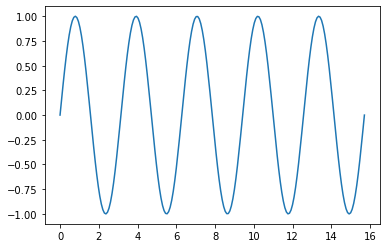

In [104]:
timesteps = 200
ncycles=5

x = np.linspace(0,ncycles*np.pi,timesteps)
siny = np.sin(2*x)
plt.plot(x,siny)

Now take slide window to get training data. ith value is predicted from previous k values

In [105]:
k = 4
X = []
y = []
for i in range(k,len(siny)):
    X.append(siny[i-k:i])
    y.append(siny[i])
X = torch.tensor(X).to(device)
y = torch.tensor(y).reshape(-1,1).to(device)
X.shape, y.shape

(torch.Size([196, 4]), torch.Size([196, 1]))

In [106]:
type(nn.MSELoss)

type

## Training a simple RNN model

I read [gist from karpathy](https://gist.github.com/karpathy/d4dee566867f8291f086) in addition to Karpathy's blog post. Using his notation, there are W_hh, W_xh, W_hy that transform the hidden state h to the next hidden state, transform's the input variable to next hidden state, and transform the hidden state to output. This [blog](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html#Creating-the-Network) was also useful but most useful was [fastai deep dive chapter](https://github.com/fastai/fastbook/blob/master/12_nlp_dive.ipynb).

In [107]:
class RNN(nn.Module):
    def __init__(self, input_features=4, output_features=1, hidden_size=10):
        super(RNN, self).__init__()
        self.output_features = output_features
        self.W_xh  = randn(hidden_size, 1, std=0.01).double()
        self.W_hh  = randn(hidden_size, hidden_size, std=0.01).double()
        self.W_hy  = randn(output_features, hidden_size, std=0.01).double()
        self.W_xh  = nn.Parameter(self.W_xh)
        self.W_hh  = nn.Parameter(self.W_hh)
        self.W_hy  = nn.Parameter(self.W_hy)
#         self.W_xh  = nn.Linear(1, hidden_size).double()
#         self.W_hh  = nn.Linear(hidden_size,    hidden_size).double()
#         self.W_hy  = nn.Linear(hidden_size,    output_features).double()
#         self.bh =   torch.zeros(hidden_size, 1, dtype=torch.float) 
#         self.by =   torch.zeros(hidden_size, 1, dtype=torch.float) 
        
    def forward(self, x):
#         print("x", x.shape)
        batch_size = x.shape[0]
        nfeatures = x.shape[1]
        h = 0 # placeholder: it's actually going to have shape len(x) by hidden_size
        for i in range(nfeatures): # for all input_features
            xi = x[:,i].reshape(1,-1)
            h += self.W_xh.mm(xi)
            foo = self.W_hh.mm(h)
            h = torch.relu(foo)
        o = self.W_hy.mm(h)
        return o.reshape(batch_size, self.output_features)

In [108]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 0.20)

In [109]:
# test model
rnn = RNN(input_features=k).to(device)
y_pred = rnn(torch.tensor(X,device=device)).detach().cpu()

/Users/parrt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [110]:
print(f"{len(X_train)} training and {len(X_valid)} test records")

157 training and 39 test records


Epoch   0 loss   0.484,   0.591   L1Loss 0.623, 0.717
Epoch  20 loss   0.036,   0.038   L1Loss 0.245, 0.212
Epoch  40 loss   0.003,   0.005   L1Loss 0.205, 0.184
Epoch  60 loss   0.001,   0.001   L1Loss 0.203, 0.183
Epoch  80 loss   0.000,   0.000   L1Loss 0.203, 0.183
Epoch 100 loss   0.000,   0.000   L1Loss 0.203, 0.183
Epoch 120 loss   0.000,   0.000   L1Loss 0.203, 0.183
Epoch 140 loss   0.000,   0.000   L1Loss 0.203, 0.183
Epoch 160 loss   0.000,   0.000   L1Loss 0.203, 0.183
Epoch 180 loss   0.000,   0.000   L1Loss 0.203, 0.183


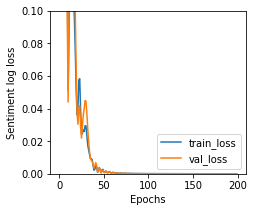

In [111]:
rnn = RNN(input_features=k, hidden_size=20).to(device)
model, history = rtrain(rnn, TensorDataset(X_train, y_train), TensorDataset(X_valid, y_valid),
                        loss_fn=torch.nn.MSELoss(),
                        metric=torch.nn.L1Loss(),
                        epochs=200,
                        learning_rate=.02,
                        weight_decay=0.0000001,
                        batch_size=32,
                        print_every=20)

plot_history(history, yrange=(0,.1))

(-1.5, 1.5)

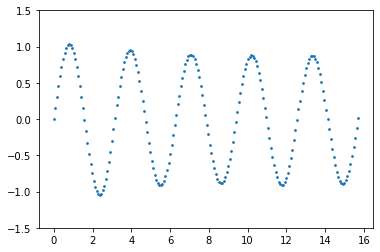

In [112]:
x = np.linspace(0,ncycles*np.pi,timesteps)
siny = np.sin(2*x)

n_output = timesteps
output = np.zeros(shape=(n_output,))
output[0:k] = siny[0:k] # seed with first k values from true data
for i in range(k,n_output):
    y_pred = rnn(torch.tensor(output[i-k:i]).reshape(1,k)).item()
#     print(i-k, ":", i-1, i, "->", y_pred)
    output[i] = y_pred

plt.scatter(x[0:n_output], output, s=3)
plt.ylim(-1.5,1.5)

**BIG LESSON**: make sure you are reinit'ing your model or creating new one. I was optimizing same model again and again, getting worse and worse results. Gotta create fresh RNN() each run.

batch_size=32 seems to be much better than 1, 2, 4, 8.  Converges too slowly.

Increasing epochs seems to get consistently decent results. 

hidden_size=50 from 10 doesn't seem to help.

hidden_size=4 is bad.

**Ooops.** modified training loop. was computing pure SGD not mini-batch loss followed by gradient and weight update. Was computing gradient each time inside mini-batch subloop. Much more stable answers from this.